In [5]:
import xmlschema

# Path to XML data file download from https://drive.google.com/drive/folders/1jcqJlnkibjPmeK0rBDskrKCRobh_6LOK?usp=drive_link
xml_file = 'awards-20230530.xml'
xsd_file = 'awards-20230530.xsd'

# Load XML schema with loose validation
schema = xmlschema.XMLSchema(xsd_file, validation='lax')

# Load XML data using XMLResource
xml_data = xmlschema.XMLResource(xml_file)

In [ ]:
# Check data for schema errors
if not schema.is_valid(xml_data):
    print("Validation Error:")
    for error in schema.iter_errors(xml_data):
        print(error)

In [6]:
# Sample element access
data = xml_data.root
data[2000].findtext('.//url')

'https://www.grantforward.com/award/detail?award_id=3049'

In [7]:
headers = set()
s = ["element_code","modified_date","ext_award_id","end_date","program_manager","abstract","fiscal_year","amount_awarded","currency","award_number","principal_investigators","recipients","award_url","program_title","source_url","start_date","cfda","award_title","all_types","all_categories","sponsors","url"]
for d in s:
    headers.add(d)
headers
        


{'abstract',
 'all_categories',
 'all_types',
 'amount_awarded',
 'award_number',
 'award_title',
 'award_url',
 'cfda',
 'currency',
 'element_code',
 'end_date',
 'ext_award_id',
 'fiscal_year',
 'modified_date',
 'principal_investigators',
 'program_manager',
 'program_title',
 'recipients',
 'source_url',
 'sponsors',
 'start_date',
 'url'}

In [32]:
import csv

csv_file = 'converted2.csv'

with open(csv_file, 'w', newline='', encoding='utf-8') as f:
    csv_writer = csv.DictWriter(f, fieldnames=headers)
    csv_writer.writeheader()

    for d in data:
        row = {header: None for header in headers}
        for child in d:
            if child.tag in headers:
                if child.tag == 'sponsors':
                    sponsors = []
                    for sponsor in child:
                        sponsors.append(child.findtext(f'.//sponsor'))
                    row['sponsors']=";".join(sponsors)
                else:
                    row[child.tag]=d.findtext(f'.//{child.tag}')
        csv_writer.writerow(row)
    

In [1]:
import pandas as pd
df = pd.read_csv('converted2.csv')

C:\Users\mohan\AppData\Local\Temp\ipykernel_13044\3980071201.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\mohan\AppData\Local\Temp\ipykernel_13044\3980071201.py:2: DtypeWarning: Columns (0,1,2,3,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('converted2.csv')


In [2]:
# i.How many awards and total amounts were awarded to the University of Illinois at Urbana-Champaign
# during the period of 2010 - 2020?

uiuc_data = df[df.recipients.isin(['University of Illinois at Urbana-Champaign'])]
uiuc_data.head(2)

,award_number,program_title,element_code,cfda,start_date,amount_awarded,award_title,award_url,url,fiscal_year,...,ext_award_id,modified_date,abstract,principal_investigators,currency,source_url,sponsors,all_types,all_categories,end_date
49174,905014.0,NETWORK SCIENCE & ENGINEERING,7794,NaN,2009-08-15,1001560.0,NetSE: Medium: A Data Mining Approach to Diagn...,https://www.nsf.gov/awardsearch/showAward?AWD_...,https://www.grantforward.com/award/detail?awar...,NaN,...,NSF 0905014,2017-06-12 11:13:48,ABSTRACT: (limited to 250 words): This award i...,Tarek Abdelzaher zaher@cs.uiuc.edu (Principal ...,USD,nsfaward.gov,Division of Computing and Communication Founda...,Research Project; Equipment/Facility/Organization,Mathematics; Computation; Science; Technology;...,2013-07-31
49177,965918.0,IGERT FULL PROPOSALS,1335,NaN,2010-08-01,3201080.0,NSF IGERT: Training the Next Generation of Res...,https://www.nsf.gov/awardsearch/showAward?AWD_...,https://www.grantforward.com/award/detail?awar...,NaN,...,NSF 0965918,2017-06-12 11:13:55,This goal of this Integrative Graduate Educati...,Rashid Bashir rbashir@illinois.edu (Principal ...,USD,nsfaward.gov,Division Of Graduate Education (DGE),Training/Course,Education; Educational Systems and Institution...,2016-07-31


In [3]:
uiuc_2010s = uiuc_data[(pd.to_datetime(uiuc_data.start_date)>=pd.to_datetime("2010-01-01")) & 
                       (pd.to_datetime(uiuc_data.start_date)<=pd.to_datetime("2020-12-31"))]
uiuc_nawards = len(uiuc_2010s)
print(f"Count of awards to the University of Illinois at Urbana-Champaign during the period of 2010-2020: {uiuc_nawards}")


Count of awards to the University of Illinois at Urbana-Champaign during the period of 2010-2020: 1946


In [4]:
from forex_python.converter import CurrencyRates
import locale

def format_currency(amount, currency='USD'):
    locale.setlocale(locale.LC_ALL, '')
    return locale.currency(amount, symbol=True, grouping=True)

def amount_calc(row):
    if row.currency == "USD":
        return row.amount_awarded
    elif row.currency is not None:
        return CurrencyRates().convert(row.currency,'USD',row.amount_awarded)
    else:
        return 0
    
uiuc_2010s.loc[:,'USD_amount_awarded'] = uiuc_2010s.apply(amount_calc,axis=1)
uiuc_sum_awards = uiuc_2010s.USD_amount_awarded.sum()
print(f"Total amount(USD) of awards to the University of Illinois at Urbana-Champaign during the period of 2010-2020: {format_currency(uiuc_sum_awards)}")

Total amount(USD) of awards to the University of Illinois at Urbana-Champaign during the period of 2010-2020: $1,148,409,140.00


C:\Users\mohan\AppData\Local\Temp\ipykernel_13044\3018757726.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uiuc_2010s.loc[:,'USD_amount_awarded'] = uiuc_2010s.apply(amount_calc,axis=1)


In [5]:
umich_data = df[df.recipients.isin(['University of Michigan'])]
umich_2010s = umich_data[(pd.to_datetime(umich_data.start_date)>=pd.to_datetime("2010-01-01")) & 
                       (pd.to_datetime(umich_data.start_date)<=pd.to_datetime("2020-12-31"))]
umich_nawards = len(umich_2010s)
print(f"Count of awards to the University of Michigan during the period of 2010-2020: {umich_nawards}")
umich_2010s.loc[:,'USD_amount_awarded'] = umich_2010s.apply(amount_calc,axis=1)
umich_sum_awards = umich_2010s.USD_amount_awarded.sum()
print(f"Total amount(USD) of awards to the University of Michigan during the period of 2010-2020: {format_currency(umich_sum_awards)}")


Count of awards to the University of Michigan during the period of 2010-2020: 33
Total amount(USD) of awards to the University of Michigan during the period of 2010-2020: $40,856,795.00


C:\Users\mohan\AppData\Local\Temp\ipykernel_13044\1508495474.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umich_2010s.loc[:,'USD_amount_awarded'] = umich_2010s.apply(amount_calc,axis=1)


In [6]:
print(f'Although UMich received very less awards,\n its amount per award ({format_currency(umich_sum_awards/umich_nawards)}) is higher than UIUC\'s ({format_currency(uiuc_sum_awards/uiuc_nawards)})')

Although UMich received very less awards,
 its amount per award ($1,238,084.70) is higher than UIUC's ($590,138.30)


In [ ]:
uiuc_data['year'] = uiuc_data.start_date.str[0:4]
umich_data['year'] = umich_data.start_date.str[0:4]

In [22]:
uiuc_data_years = uiuc_data[['year','amount_awarded']].groupby(['year'])['amount_awarded'].sum()
umich_data_years = umich_data[['year','amount_awarded']].groupby(['year'])['amount_awarded'].sum()


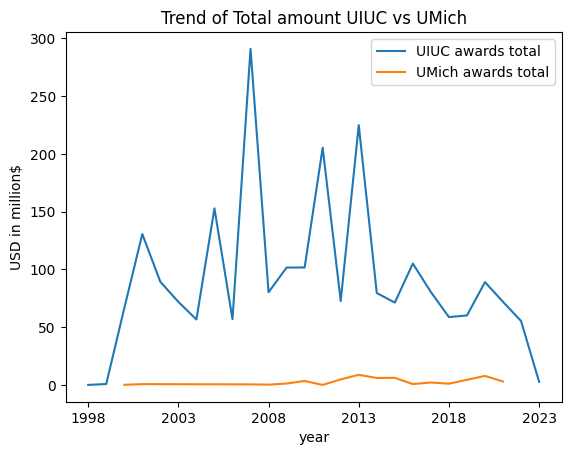

In [36]:
import matplotlib.pyplot as plt

plt.plot(uiuc_data_years.keys(), uiuc_data_years.values/1000000, label='UIUC awards total')
plt.plot(umich_data_years.keys(), umich_data_years.values/1000000, label='UMich awards total')

plt.xlabel('year')
plt.ylabel('USD in million$')
plt.title('Trend of Total amount UIUC vs UMich')
plt.xticks(uiuc_data_years.keys()[::5])
plt.legend()

plt.show()